# Homework #3

Adarsh Mallya  
10/03/2025

I chose Option 1: Implementing a different loss function

## Problem 3.1

The loss function I decided to implement was the cross-entropy loss function, defined as:

$$
L = - \sum_{i=1}^C [y_i log (\hat{y}_i) + (1 - y_i) log(1 - \hat{y}_i)]
$$

Cross-entropy loss functions are typically used for classification problems, while mean squared error functions are usually used in linear regression problems. This might make the cross-entropy loss function a better fit for the MNIST classifier.

## Problem 3.2

Calculating the gradient of the cross entropy loss function is a little different than the mean squared error function. Because the gradient needs to be computed with respect to each of the class predictions, we are trying to find $\frac{\partial{L}}{\partial{z_i}}$.

$$
L = - \sum_{i=1}^C [y_i log (\hat{y}_i) + (1 - y_i) log(1 - \hat{y}_i)]
$$

First, find the derivative of the sigmoid activation function:

$$
\frac{d\hat{y_i}}{dz_i} = \hat{y_i}(1 - \hat{y_i})
$$

Now we differentiate the loss function with respect to $\hat{y_i}$

$$
\frac{\partial{L}}{\partial{\hat{y_i}}} = -\frac{y_i}{\hat{y_i}} + \frac{1 - y_i}{1 - \hat{y_i}}
$$

This means the value of our gradient is:

$$
\frac{\partial{L}}{\partial{z_i}} = \frac{\partial{L}}{\partial{\hat{y_i}}} \cdot \frac{d\hat{y_i}}{dz_i} = (-\frac{y_i}{\hat{y_i}} + \frac{1 - y_i}{1 - \hat{y_i}})(\hat{y_i}(1 - \hat{y_i})) = \hat{y_i} - y_i
$$

## Problem 3.3

We need to modify the definition of our multilayer perceptron to use the cross entropy function as its loss function.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import struct
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
print('Using device: '+device_name)
device = torch.device(device_name)

Using device: mps


In [3]:
def read_mnist_images(data_directory, subset='train'):
    if subset=='train':
        prefix = 'train-'
    else:
        prefix = 't10k-'
        
    with open(os.path.join('MNIST',prefix+'images.idx3-ubyte'), 'rb') as f:
        # unpack header
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        
        # read image data
        image_data = f.read(num_images * num_rows * num_cols)
        images = np.frombuffer(image_data, dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)

    with open(os.path.join('MNIST',prefix+'labels.idx1-ubyte'), 'rb') as f:
        # unpack header
        _, num_labels = struct.unpack('>II', f.read(8))

        # read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

        
    return images, labels

In [4]:
# load in the training and test images
train_images, train_labels = read_mnist_images('MNIST','train')
test_images, test_labels = read_mnist_images('MNIST','test')

# reshape as before
X_train = train_images.reshape(-1, 784) / 255.0
X_test = test_images.reshape(-1, 784) / 255.0
y_train = train_labels
y_test = test_labels

In [5]:
# create PyTorch tensor versions of the MNIST data
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

In [6]:
# create one-hot encoded training label tensors
y_train_onehot = F.one_hot(y_train_tensor.to(torch.int64), num_classes=10).float()
y_test_onehot = F.one_hot(y_test_tensor.to(torch.int64), num_classes=10).float()

In [10]:
# make a TensorDataset object for the training data
ds_train = TensorDataset(X_train_tensor, y_train_onehot)

# make a loader object for the training data
train_loader = DataLoader(ds_train, batch_size=64, shuffle=True)

In [11]:
# make a TensorDataset object for the test data
ds_test = TensorDataset(X_test_tensor, y_test_onehot)

# make a loader object for the test data
test_loader = DataLoader(ds_test, batch_size=64, shuffle=False)


In [12]:
# implement an MLP class here
class MLP(nn.Module):

    def __init__(self, in_dim=784, hidden_dim=50, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        h = torch.sigmoid(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out

In [13]:
# make an mlp object here
mlp = MLP().to(device)

In [14]:
# define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.5)

## Problem 3.4

Now we need to train our re-defined MLP model on the dataset of MNIST images.

In [15]:
# implement a training and testing loop here

# make empty arrays to store the losses for each epoch
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# loop through each epoch
for epoch in range(10):

    #- Testing Block --------------------------------
    mlp.train()
    total_loss, correct, total = 0, 0, 0

    # loop through mini-batches in the data loader
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # forward
        p = mlp(x)
        
        # backward
        loss = criterion(p, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute the total loss
        total_loss += loss.item() * x.size(0)
        # predictions (argmax across 10 classes)
        pred = p.argmax(dim=1)
        true = y.argmax(dim=1)
        correct += (pred == true).sum().item() 
        total += x.size(0)
        
    train_loss = total_loss/total
    train_acc = correct/total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"epoch {epoch+1}: loss={total_loss/total:.4f}, acc={correct/total:.3f}")
    # ---- Evaluation (Testing/Validation) ----
    mlp.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            p = mlp(x)
            loss = criterion(p, y)
            total_loss += loss.item() * x.size(0)
            pred = p.argmax(dim=1)
            true = y.argmax(dim=1)
            correct += (pred == true).sum().item() 
            total += x.size(0)
    test_loss = total_loss/total
    test_acc = correct/total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

epoch 1: loss=1.8331, acc=0.745
epoch 2: loss=1.6334, acc=0.873
epoch 3: loss=1.5946, acc=0.895
epoch 4: loss=1.5729, acc=0.909
epoch 5: loss=1.5603, acc=0.915
epoch 6: loss=1.5521, acc=0.920
epoch 7: loss=1.5462, acc=0.923
epoch 8: loss=1.5416, acc=0.926
epoch 9: loss=1.5378, acc=0.929
epoch 10: loss=1.5347, acc=0.931


## Problem 3.5

Let's visualize the model performance for the model with this new loss function.

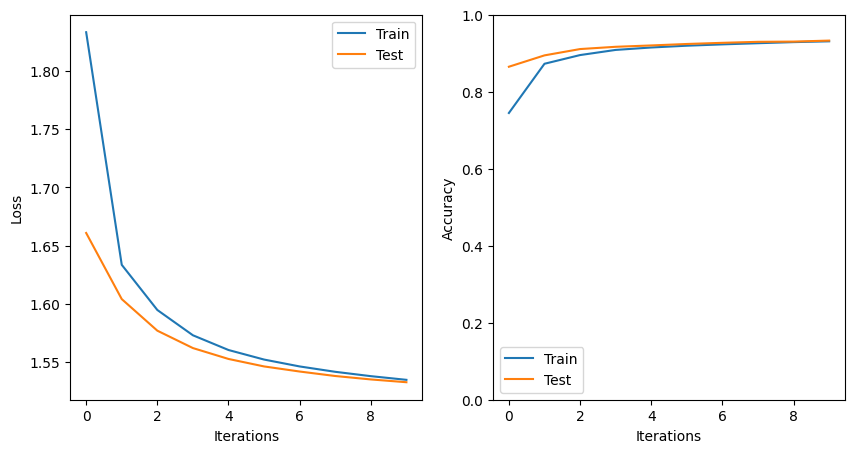

In [16]:
# plot the losses and accuracies
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(train_losses,label='Train')
plt.plot(test_losses,label='Test')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs,label='Train')
plt.plot(test_accs,label='Test')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('Iterations')
plt.show()

As a reminder, here's what the model performance was with MSE as the loss function:

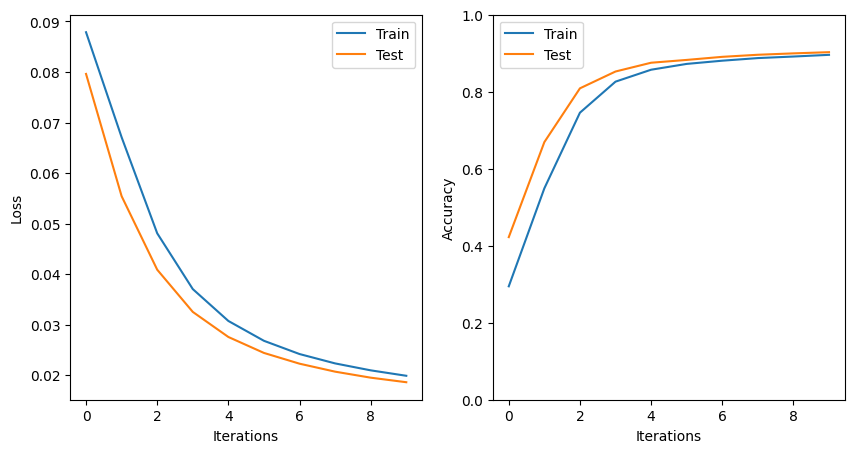

The accuracy peaked at a higher spot on the cross entropy loss model than the MSE model, as seen in the graph. I thought it was curious how the loss value for the cross entropy loss model was above 1, which must have to do with some sort of data standardization that should have been done before the loss function was changed. It appears that the cross entropy loss function might be more appropriate for this kind of classification task, where there are more than two classes that can be classified.